In [14]:

pip install tpot

     |████████████████████████████████| 87 kB 9.6 MB/s             
     |████████████████████████████████| 160 kB 59.7 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=a57b43c2c7575cea064b7bb50de92428aaaee4388c570deeae713bae709ced13
  Stored in directory: /home/datalore/.cache/pip/wheels/a8/bb/8f/6b9328d23c2dcedbfeb8498b9f650d55d463089e3b8fc0bfb2
Successfully built stopit
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install auto-sklearn

     |████████████████████████████████| 6.4 MB 20.6 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 24.9 MB 48.7 MB/s            
     |████████████████████████████████| 1.1 MB 66.8 MB/s            
     |████████████████████████████████| 856 kB 64.7 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 4.9 MB 61.6 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 3.9 MB 35.4 MB/s            
     |████████████████████████████████| 260 kB 59.3 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 1.9 MB 60.9 MB/s            
     |████████████████████████████████| 55 kB 7.1 MB/s             
     |████████████████████████████████| 136 kB 65.1 MB/s            
     |████████████████████████████████| 322 kB 66.6 MB/s            
     |████████████████████████████████| 283 kB 67.1 MB/s     

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn import model_selection
import seaborn as sns
import random
from sklearn.model_selection import KFold

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from tpot import TPOTRegressor
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_absolute_error

In [2]:
def show_correlation_coefficient(data_df,method):
    sns.set(font_scale=1)
    df_corr = data_df.corr(method=method, min_periods=1)
    plt.figure(figsize=(18,14))
    sns.heatmap(df_corr, xticklabels = df_corr.columns, yticklabels = df_corr.columns, annot=True,
            linewidths=0.5)

In [3]:
def show_distribution_diagram(data, name):
    sns.set(font_scale=1)
    variable = data[name].fillna(data.mean())
    sns.displot(data=variable, kind="kde", multiple="stack")
    plt.show()

In [4]:
class YieldStressPredict:
    def __init__(self,tpot,auto_sklearn=None):
        self.tpot = tpot
        self.auto_sklearn = auto_sklearn
        

    def fit(self, X_train, y_train):
        self.tpot = self.tpot.fit(X_train,y_train)
        self.auto_sklearn = self.auto_sklearn.fit(X_train,y_train)
        self.X_train = X_train
        self.y_train = y_train
        

    def get_best_pipeline(self,name):
        self.tpot.export("tpot_export"+name+".py")
        result = self.auto_sklearn.cv_results_
        df = pd.DataFrame(result)
        df.to_csv("autosklearn" + name + ".csv")
        

    def predict(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.tpot_predict = self.tpot.predict(X_test)
        self.auto_sklearn_predict = self.auto_sklearn.predict(X_test)

    def mean_squared_error(self,name):
        y_predict = []
        if name == 'tpot':
            y_predict = self.tpot_predict
        elif name == 'auto_sklearn':
            y_predict = self.auto_sklearn_predict

        mse = mean_squared_error(self.y_test, y_predict)
        return mse
    def mean_absolute_error(self,name):
        y_predict = []
        if name == 'tpot':
            y_predict = self.tpot_predict
        elif name == 'auto_sklearn':
            y_predict = self.auto_sklearn_predict
        mae = mean_absolute_error(self.y_test,y_predict)
        return  mae
    def r2_score(self,name):
        y_predict = []
        if name == 'tpot':
            y_predict = self.tpot_predict
        elif name == 'auto_sklearn':
            y_predict = self.auto_sklearn_predict
        r2 = r2_score(self.y_test, y_predict)
        return r2
    
    def show_deviance_diagrams(self,model_name):
        test_score = np.zeros((self.params["n_estimators"],), dtype=np.float64)
        for i, y_pred in enumerate(self.reg.staged_predict(self.X_test)):
            test_score[i] = self.reg.loss_(self.y_test, y_pred)

        fig = plt.figure(figsize=(6, 6))
        plt.subplot(1, 1, 1)
        plt.title("Deviance of: " + model_name)
        plt.plot(
            np.arange(self.params["n_estimators"]) + 1, self.reg.train_score_, "b-", label="Training Set Deviance", )
        plt.plot(np.arange(self.params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance")
        plt.legend(loc="upper right")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance")
        fig.tight_layout()
        plt.show()

    def show_tpot_features_importance(self,model_name):
        feature_names = self.X_train.columns
        best_model = self.tpot.fitted_pipeline_.steps[-1][1]
        best_model.fit(self.X_train,self.y_train)
        feature_importance = best_model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + 0.5
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.barh(pos, feature_importance[sorted_idx], align="center")
        plt.yticks(pos, np.array(feature_names)[sorted_idx])
        plt.title("Feature Importance (MDI) of: " + model_name)

        result = permutation_importance(
            best_model, self.X_test, self.y_test, n_repeats=10, random_state=13, n_jobs=2
        )
        sorted_idx = result.importances_mean.argsort()
        plt.subplot(1, 2, 2)
        plt.boxplot(
            result.importances[sorted_idx].T,
            vert=False,
            labels=np.array(feature_names)[sorted_idx],
        )
        plt.title("Permutation Importance (test set)")
        fig.tight_layout()
        plt.show()


def train_test_split(data_df, target_feature_name, test_size, random_state):
    X = data_df.drop([target_feature_name], axis=1)
    y = data_df[target_feature_name]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)
    return (X_train, X_test, y_train, y_test)




	
    

In [5]:
def save_y_predict(y_true, tpot_predict, auto_predict, filename):
    y_true = y_true.to_list()
    # tpot_predict = tpot_predict.to_list()
    # auto_predict = auto_predict.to_list()
    with open(filename, "a+") as outputfile:
        print(y_true)
        print(len(y_true))
        for i in range(0, len(y_true)):
            newrow = [y_true[i], tpot_predict[i], auto_predict[i],
                      abs(tpot_predict[i] - y_true[i]) / y_true[i], abs(auto_predict[i] - y_true[i]) / y_true[i] ]
            newrow = [str(i) for i in newrow]
            line = ",".join(newrow)
            outputfile.write(line + "\n")

    # dt['y_true'] = dt['y_true'].add(y_true)
    # dt['tpot_predict']= dt['tpot_predict'].add(tpot_predict)
    # dt['auto_sklearn_predict']= dt['auto_sklearn_predict'].add(auto_predict)
    # dt['tpot_error']=dt['tpot_error'].add([(abs(e1-e2)/e1)  for (e1, e2) in zip(y_true, tpot_predict)])
    # dt['auto_sklearn_error']=dt['auto_sklearn_error'].add([(abs(e1-e2)/e1)  for (e1, e2) in zip(y_true, tpot_predict)])


def compare_frameworks(ys_prediction, data_df, target_feature, test_size,
                       number_of_iterations, file_stats_name, y_stats_filename):
    filename = file_stats_name
    stats_df = pd.read_csv(filename)
    row_number = len(stats_df.index)
    start_index = 0
    if row_number == 0:
        #
        stats_df.columns = ["Times", "random_state", "MAE", "MSE", "R2", "type"]
        stats_df.to_csv(filename)
    if row_number > 1:
        first_column = stats_df.iloc[:, 0]
        start_index = first_column[row_number - 1] + 1
    for i in range(number_of_iterations):
        random_state = random.randint(1, 12341251)
        X_train, X_test, y_train, y_test = train_test_split(data_df, target_feature, test_size, random_state)

        # traings model
        ys_prediction.fit(X_train, y_train)
        # predict test data
        ys_prediction.predict(X_test,y_test)
        
        save_y_predict(y_test, ys_prediction.tpot_predict,
                       ys_prediction.auto_sklearn_predict, y_stats_filename)

        mae = ys_prediction.mean_absolute_error(name='tpot')
        mse = ys_prediction.mean_squared_error(name='tpot')
        r2 = ys_prediction.r2_score(name='tpot')
        ys_prediction.get_best_pipeline(str(i + start_index))
        newline1 = "{},{},{},{},{},{}\n".format(i + start_index, random_state, mae, mse, r2, 'tpot')
        mae = ys_prediction.mean_absolute_error(name='auto_sklearn')
        mse = ys_prediction.mean_squared_error(name='auto_sklearn')
        r2 = ys_prediction.r2_score(name='auto_sklearn')
        newline2 = "{},{},{},{},{},{}\n".format(i + start_index, random_state, mae, mse, r2, 'auto_sklearn')

        with open(filename, 'a') as f:
            f.write(newline1)
            f.write(newline2)
    return ys_prediction
            

In [6]:
filename = "YieldStress_database.csv"
fw_stats_filename = "framework_stats.csv"
y_predict_stats_filename = "y_predict_stats.csv"
target_feature = "YS (MPa)"
data_df = pd.read_csv(filename)
data_df = data_df.iloc[:, 1:]



In [7]:
# x_train,X_test,y_train,y_test = train_test_split(data_df,target_feature,0.3,120)
# save_y_predict(y_test,y_test,y_test,y_predict_stats_filename)

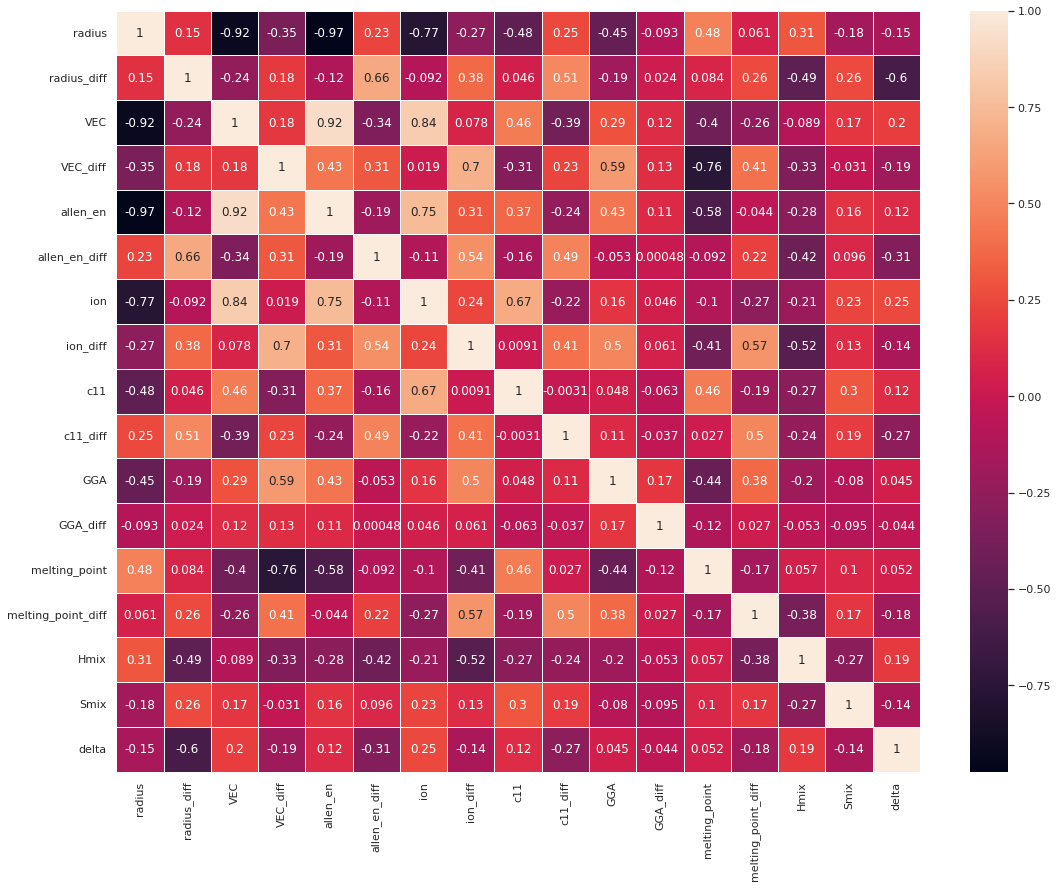

In [8]:
show_correlation_coefficient(data_df=data_df.drop([target_feature],axis = 1),method = "pearson")

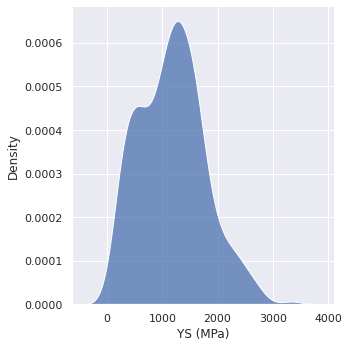

In [9]:
show_distribution_diagram(data_df,target_feature)

In [10]:
cv = KFold(n_splits=5)
tpot_params = {
    "scoring": 'neg_mean_absolute_error',
    "cv": cv,
    "random_state": 1331,
    "verbosity": 3,
    "n_jobs": -1,
    "generations": 30,
    "population_size": 10,
    "max_eval_time_mins": 3
}

auto_sklearn_params = {
    "scoring_functions": [mean_absolute_error],
    "per_run_time_limit": 180,
    "seed": 1331,
    "resampling_strategy_arguments": {'cv': {'folds': 5}},
    "max_models_on_disc":10,
    "n_jobs": -1,
}
tpot = TPOTRegressor(**tpot_params)
auto_sklearn = AutoSklearnRegressor(**auto_sklearn_params)
yield_stress_predict = YieldStressPredict(tpot, auto_sklearn)

In [11]:
compare_frameworks(yield_stress_predict, data_df, target_feature, 0.2, 1,fw_stats_filename,y_predict_stats_filename)

30 operators have been imported by TPOT.
_pre_test decorator: _random_mutation_operator: num_test=0 [17:43:21] ../src/learner.cc:602: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) /opt/python/envs/default/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x19c8d9) [0x7ff783c418d9]
  [bt] (1) /opt/python/envs/default/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1b1f1b) [0x7ff783c56f1b]
  [bt] (2) /opt/python/envs/default/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1b9b4d) [0x7ff783c5eb4d]
  [bt] (3) /opt/python/envs/default/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1b4559) [0x7ff783c59559]
  [bt] (4) /opt/python/envs/default/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7ff783b3e4e8]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7ff7fd9b1ff5]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7ff7f

In [12]:
from matplotlib.ticker import FuncFormatter

def show_diagram_two_model(filename,number_point,aspect,height):
    result = pd.read_csv(filename)
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    new_result = result
    new_result['MAE'] *= -1
    new_result = new_result.drop([result.columns[2],result.columns[3],result.columns[4]],axis = 1)
    for i in range(2, 5):
        property_name = result.columns[i]
        data = result[property_name]
        df = new_result
        df[property_name] = data
        g = sns.catplot(data=df, kind="point", x='Times', y=property_name, hue='type', ci=None, palette="dark", aspect=aspect, height=aspect)
        ax = g.fig.gca()
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    
    

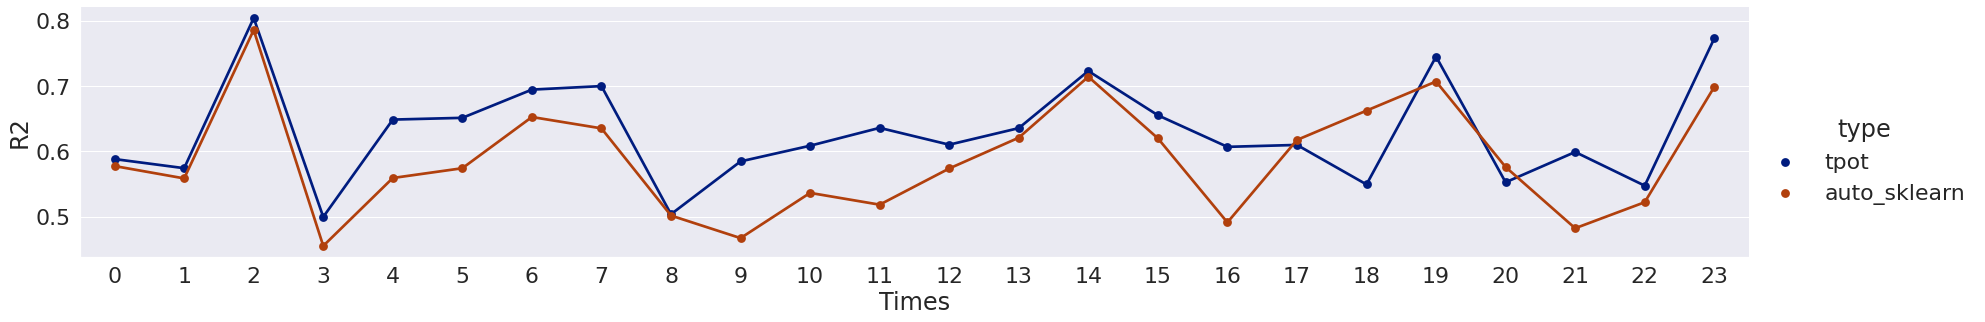

In [13]:
show_diagram_two_model(fw_stats_filename,100,5,5)

138
138
138


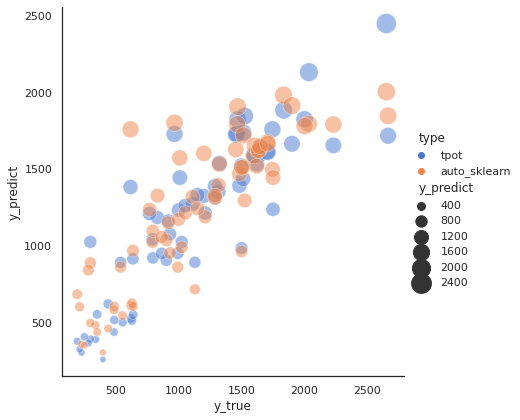

In [10]:

sns.set_theme(style="white")

# Load the example mpg dataset
y_stats = pd.read_csv(y_predict_stats_filename)
y_true = y_stats['y_true'].to_list()
y_true += y_true

y_predict = []
y_predict += (y_stats['tpot_predict'].to_list())
y_predict += (y_stats['auto_sklearn_predict'].to_list())
type_dict = []
type_dict += (['tpot'] * len(y_stats['tpot_predict']))
type_dict += (['auto_sklearn'] * len(y_stats['auto_sklearn_predict']))
print(len(y_true))
print(len(y_predict))
print(len(type_dict))

columns = {'y_true':y_true,
        'y_predict': y_predict,
        'type': type_dict}
df_predict = pd.DataFrame(columns)

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="y_true", y="y_predict", hue="type", size="y_predict",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df_predict)

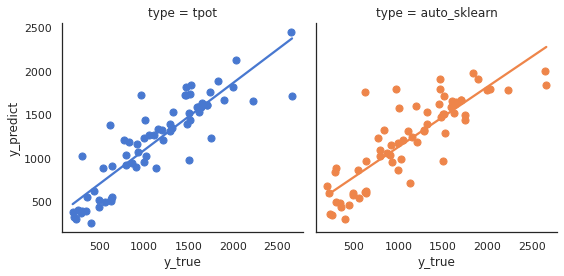

In [13]:
sns.lmplot(x="y_true", y="y_predict", hue="type", col="type", data=df_predict,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})